In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import os

In [2]:
# dissolution_tank.csv
# 식품가공 기업의 작업환경 개선 및 생산성 향상을 위한 아이디어를 제시하고 인공지능 알고리즘으로 구현
'''

무엇을 해야할지 고민을 해야함 / 어떠한 문제 해결에 초점을 두어야 하는지 확인...

1. 알고리즘 선정하기 전 / 어떠한 인사이트로 분석할 것인가? (예를 들어서, 불량품예측 모델 / 장비고장 예측) 
 * 독립변수 및 종속변수 선정하기

2. 알고리즘 선정 - 클러스트링 의사결정 나무 시계열 모형

3. 학습 및 평가 
'''

'\n\n무엇을 해야할지 고민을 해야함 / 어떠한 문제 해결에 초점을 두어야 하는지 확인...\n\n1. 알고리즘 선정하기 전 / 어떠한 인사이트로 분석할 것인가? (예를 들어서, 불량품예측 모델 / 장비고장 예측) \n * 독립변수 및 종속변수 선정하기\n\n2. 알고리즘 선정 - 클러스트링 의사결정 나무 시계열 모형\n\n3. 학습 및 평가 \n'

In [91]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


In [ ]:
# /Users/wani/Desktop/
file_path = './datasets/'

In [5]:
dissoultion = pd.read_csv(file_path + 'dissolution_tank.csv', encoding='cp949')
dissoultion

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59,835195,755,1743,318,3.21,OK
835196,2020-04-30 23:59,835196,385,206,317,3.19,OK
835197,2020-04-30 23:59,835197,465,148,316,3.20,OK
835198,2020-04-30 23:59,835198,467,0,314,3.19,OK


In [6]:
# 이상치 탐지 ...
def outlier_iqr(data, column): 
    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]    
    
    # 1사 4사 분위에 속하는 데이터 조건에 저장
    condition1 = data[column] > upper
    condition2 = data[column] < lower
    a1 = data[condition1].index
    a2 = data[condition2].index
    data.drop(a1, inplace = True)
    data.drop(a2, inplace = True)
    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다, 제거 완료')

    #print(len(data2))

In [7]:
#MELT_TEMP
print('=======MELT_TEMP=======')
outlier_iqr(dissoultion,'MELT_TEMP')



=======MELT_TEMP=======
IQR은 72.0 이다.
lower bound 값은 322.0 이다.
upper bound 값은 610.0 이다.
총 이상치 개수는 167059 이다, 제거 완료


In [8]:
dissoultion

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
6,2020-03-04 0:00,6,390,212,602,3.19,OK
...,...,...,...,...,...,...,...
835193,2020-04-30 23:59,835193,391,213,320,3.18,OK
835196,2020-04-30 23:59,835196,385,206,317,3.19,OK
835197,2020-04-30 23:59,835197,465,148,316,3.20,OK
835198,2020-04-30 23:59,835198,467,0,314,3.19,OK


In [9]:
#MELT_TEMP
print('=======MOTORSPEED=======')
outlier_iqr(dissoultion,'MOTORSPEED')

#MELT_WEIGHT
print('=======MELT_WEIGHT=======')
outlier_iqr(dissoultion,'MELT_WEIGHT')

#INSP
print('=======INSP=======')
outlier_iqr(dissoultion,'INSP')

=======MOTORSPEED=======
IQR은 89.0 이다.
lower bound 값은 -34.5 이다.
upper bound 값은 321.5 이다.
총 이상치 개수는 0 이다, 제거 완료
=======MELT_WEIGHT=======
IQR은 396.0 이다.
lower bound 값은 -408.0 이다.
upper bound 값은 1176.0 이다.
총 이상치 개수는 36544 이다, 제거 완료
=======INSP=======
IQR은 0.0 이다.
lower bound 값은 3.19 이다.
upper bound 값은 3.19 이다.
총 이상치 개수는 175650 이다, 제거 완료


In [11]:
dissolT_NG = dissoultion[dissoultion['TAG'].str.contains('NG')]
dissolT_NG

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
188826,2020-03-17 2:42,188826,362,203,61,3.19,NG
188903,2020-03-17 2:50,188903,365,238,151,3.19,NG
188913,2020-03-17 2:51,188913,374,203,203,3.19,NG
188923,2020-03-17 2:52,188923,361,236,253,3.19,NG
188996,2020-03-17 2:59,188996,343,218,622,3.19,NG
...,...,...,...,...,...,...,...
598507,2020-04-14 13:30,598507,454,178,344,3.19,NG
598551,2020-04-14 13:35,598551,458,73,269,3.19,NG
598567,2020-04-14 13:36,598567,452,156,236,3.19,NG
598597,2020-04-14 13:39,598597,455,160,177,3.19,NG


In [12]:
dissolT_OK = dissoultion[dissoultion['TAG'].str.contains('OK')]
dissolT_OK

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
6,2020-03-04 0:00,6,390,212,602,3.19,OK
...,...,...,...,...,...,...,...
835189,2020-04-30 23:58,835189,490,105,325,3.19,OK
835191,2020-04-30 23:59,835191,449,80,322,3.19,OK
835192,2020-04-30 23:59,835192,486,159,321,3.19,OK
835196,2020-04-30 23:59,835196,385,206,317,3.19,OK


In [126]:
dissolT_NG[dissolT_NG['INSP'] != 3.19] 

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG


In [13]:
#replace(24, 100)
dissoultion = dissoultion.replace('OK', 0) # 정상 OK 0, 불량 NG 1 //
dissoultion = dissoultion.replace('NG', 1)

In [16]:
dissoul = dissoultion.copy()
dissoul # 데이터 프레임 복사함 / 

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,0
1,2020-03-04 0:00,1,433,78,609,3.19,0
2,2020-03-04 0:00,2,464,154,608,3.19,0
3,2020-03-04 0:00,3,379,212,606,3.19,0
6,2020-03-04 0:00,6,390,212,602,3.19,0
...,...,...,...,...,...,...,...
835189,2020-04-30 23:58,835189,490,105,325,3.19,0
835191,2020-04-30 23:59,835191,449,80,322,3.19,0
835192,2020-04-30 23:59,835192,486,159,321,3.19,0
835196,2020-04-30 23:59,835196,385,206,317,3.19,0


In [64]:
dissoul_MnX = dissoultion.copy()
dissoul_MnX # 데이터 프레임 복사함 / dissoul_MnX

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,0
1,2020-03-04 0:00,1,433,78,609,3.19,0
2,2020-03-04 0:00,2,464,154,608,3.19,0
3,2020-03-04 0:00,3,379,212,606,3.19,0
6,2020-03-04 0:00,6,390,212,602,3.19,0
...,...,...,...,...,...,...,...
835189,2020-04-30 23:58,835189,490,105,325,3.19,0
835191,2020-04-30 23:59,835191,449,80,322,3.19,0
835192,2020-04-30 23:59,835192,486,159,321,3.19,0
835196,2020-04-30 23:59,835196,385,206,317,3.19,0


In [69]:
dissoul_MnX[dissoul_MnX['INSP'] != 3.19]  # 이상치 제거 후, INSP

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG


In [31]:
#그렇다면 우리는 모델을 오직 정상
dissoul['MELT_TEMP'] = StandardScaler().fit_transform(dissoul['MELT_TEMP'].values.reshape(-1, 1))
dissoul['MOTORSPEED'] = StandardScaler().fit_transform(dissoul['MOTORSPEED'].values.reshape(-1, 1))
dissoul['MELT_WEIGHT'] = StandardScaler().fit_transform(dissoul['MELT_WEIGHT'].values.reshape(-1, 1))
dissoul['INSP'] = StandardScaler().fit_transform(dissoul['INSP'].values.reshape(-1, 1))

In [70]:
# Minmax scaling / 우리는 모델을 오직 정상
dissoul_MnX['MELT_TEMP'] = MinMaxScaler().fit_transform(dissoul_MnX['MELT_TEMP'].values.reshape(-1, 1))
dissoul_MnX['MOTORSPEED'] =  MinMaxScaler().fit_transform(dissoul_MnX['MOTORSPEED'].values.reshape(-1, 1))
dissoul_MnX['MELT_WEIGHT'] =  MinMaxScaler().fit_transform(dissoul_MnX['MELT_WEIGHT'].values.reshape(-1, 1))
dissoul_MnX['INSP'] =  MinMaxScaler().fit_transform(dissoul_MnX['INSP'].values.reshape(-1, 1))
dissoul_MnX

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,0.690083,0.431227,0.536565,0.0,0
1,2020-03-04 0:00,1,0.458678,0.289963,0.517857,0.0,0
2,2020-03-04 0:00,2,0.586777,0.572491,0.517007,0.0,0
3,2020-03-04 0:00,3,0.235537,0.788104,0.515306,0.0,0
6,2020-03-04 0:00,6,0.280992,0.788104,0.511905,0.0,0
...,...,...,...,...,...,...,...
835189,2020-04-30 23:58,835189,0.694215,0.390335,0.276361,0.0,0
835191,2020-04-30 23:59,835191,0.524793,0.297398,0.273810,0.0,0
835192,2020-04-30 23:59,835192,0.677686,0.591078,0.272959,0.0,0
835196,2020-04-30 23:59,835196,0.260331,0.765799,0.269558,0.0,0


In [71]:
dissoul_MnX[dissoul_MnX['TAG'] == 1] 

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
188826,2020-03-17 2:42,188826,0.165289,0.754647,0.051871,0.0,1
188903,2020-03-17 2:50,188903,0.177686,0.884758,0.128401,0.0,1
188913,2020-03-17 2:51,188913,0.214876,0.754647,0.172619,0.0,1
188923,2020-03-17 2:52,188923,0.161157,0.877323,0.215136,0.0,1
188996,2020-03-17 2:59,188996,0.086777,0.810409,0.528912,0.0,1
...,...,...,...,...,...,...,...
598507,2020-04-14 13:30,598507,0.545455,0.661710,0.292517,0.0,1
598551,2020-04-14 13:35,598551,0.561983,0.271375,0.228741,0.0,1
598567,2020-04-14 13:36,598567,0.537190,0.579926,0.200680,0.0,1
598597,2020-04-14 13:39,598597,0.549587,0.594796,0.150510,0.0,1


In [72]:
dissoul_MnX[dissoul_MnX['TAG'] == 0] 

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,0.690083,0.431227,0.536565,0.0,0
1,2020-03-04 0:00,1,0.458678,0.289963,0.517857,0.0,0
2,2020-03-04 0:00,2,0.586777,0.572491,0.517007,0.0,0
3,2020-03-04 0:00,3,0.235537,0.788104,0.515306,0.0,0
6,2020-03-04 0:00,6,0.280992,0.788104,0.511905,0.0,0
...,...,...,...,...,...,...,...
835189,2020-04-30 23:58,835189,0.694215,0.390335,0.276361,0.0,0
835191,2020-04-30 23:59,835191,0.524793,0.297398,0.273810,0.0,0
835192,2020-04-30 23:59,835192,0.677686,0.591078,0.272959,0.0,0
835196,2020-04-30 23:59,835196,0.260331,0.765799,0.269558,0.0,0


In [107]:
X_train, X_test = train_test_split(dissoul_MnX, test_size=0.2, random_state=74)
X_train = X_train[dissoul_MnX.TAG == 0]
X_train = X_train.drop(['STD_DT'], axis = 1)
X_train = X_train.drop(['NUM'], axis = 1)
X_train = X_train.drop(['TAG'], axis=1)
X_train = X_train.drop(['INSP'], axis=1)

y_test = X_test['TAG']
X_test = X_test.drop(['TAG'], axis=1)
X_test = X_test.drop(['INSP'], axis=1)
X_test = X_test.drop(['STD_DT'], axis = 1)
X_test = X_test.drop(['NUM'], axis = 1)


X_train = X_train.values
X_test = X_test.values

X_train.shape

/var/folders/ts/qlqc0dr52sn_xpkshw60mrmr0000gn/T/ipykernel_38476/1020502173.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[dissoul_MnX.TAG == 0]


(269251, 3)

In [108]:
X_train.astype(float)
X_test.astype(float)

array([[0.51652893, 0.        , 0.03146259],
       [0.66528926, 0.48327138, 0.25680272],
       [0.47107438, 0.2527881 , 0.17091837],
       ...,
       [0.48347107, 0.27881041, 0.22534014],
       [0.53305785, 0.31226766, 0.18367347],
       [0.53305785, 0.20446097, 0.3792517 ]])

In [79]:
#X_train


array([['2020-03-04 15:21', 9218, 0.5330578512396695, 0.2899628252788104,
        0.07738095238095238],
       ['2020-03-08 6:14', 61349, 0.6198347107438018, 0.4758364312267658,
        0.5603741496598639],
       ['2020-03-10 11:15', 93153, 0.4173553719008265,
        0.8066914498141263, 0.37755102040816324],
       ...,
       ['2020-03-04 21:16', 12763, 0.2024793388429753,
        0.7509293680297398, 0.03996598639455782],
       ['2020-04-07 18:34', 500742, 0.5826446280991735,
        0.7509293680297398, 0.29166666666666663],
       ['2020-04-02 4:52', 420527, 0.6280991735537191,
        0.7211895910780669, 0.9013605442176871]], dtype=object)

In [95]:
X_train

array([[0.53305785, 0.28996283, 0.07738095],
       [0.61983471, 0.47583643, 0.56037415],
       [0.41735537, 0.80669145, 0.37755102],
       ...,
       [0.20247934, 0.75092937, 0.03996599],
       [0.58264463, 0.75092937, 0.29166667],
       [0.62809917, 0.72118959, 0.90136054]])

In [82]:
input_dim = X_train.shape[1]
print(input_dim)


3


In [109]:
# 우리가 만들 Autoencoder는 4개의 fully connected layer로 만들어져 있으며, 각 layer는 14, 7, 7, 29개의 뉴런으로 구성
# 두 개의 layer들은 encoder로 쓰이며, 뒤의 두 개는 decoder가 됩니다. 또, L1 정규화(regularization)를 사용

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


In [110]:
# 00 에폭(epoch) 동안 16의 배치 사이즈(batch size
nb_epoch = 100
batch_size = 16
autoencoder.compile(optimizer='adam', loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h7", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)



2022-10-31 16:16:44.260236: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 16:16:44.260256: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-31 16:16:44.260740: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


s


In [111]:
history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size,
                    shuffle=True, validation_data=(X_test, X_test), verbose=1, 
                          callbacks=[checkpointer, tensorboard]).history # MinMax scale // error -> list type floating


Epoch 1/100
  237/16829 [..............................] - ETA: 14s - loss: 0.0406 - accuracy: 0.6493    

2022-10-31 16:16:45.873192: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 16:16:45.873209: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-31 16:16:45.893748: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-31 16:16:45.894471: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-31 16:16:45.895359: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_10_31_16_16_45

2022-10-31 16:16:45.896599: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_10_31_16_16_45/waniui-MacBook-Pro.local.trace.json.gz
2022-10-31 16:16:45.899989: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_10_31_16_16_45

2022-10-31 

16829/16829 [==============================] - 14s 819us/step - loss: 7.6034e-04 - accuracy: 0.9891 - val_loss: 3.9703e-05 - val_accuracy: 0.9982


2022-10-31 16:16:59.981519: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model.h7/assets
Epoch 2/100
16829/16829 [==============================] - 13s 796us/step - loss: 2.4335e-05 - accuracy: 0.9973 - val_loss: 2.2785e-05 - val_accuracy: 0.9950
INFO:tensorflow:Assets written to: model.h7/assets
Epoch 3/100
16829/16829 [==============================] - 14s 854us/step - loss: 1.4145e-05 - accuracy: 0.9970 - val_loss: 1.7158e-05 - val_accuracy: 0.9918
INFO:tensorflow:Assets written to: model.h7/assets
Epoch 4/100
16829/16829 [==============================] - 14s 842us/step - loss: 1.0821e-05 - accuracy: 0.9967 - val_loss: 1.0755e-05 - val_accuracy: 0.9966
INFO:tensorflow:Assets written to: model.h7/assets
Epoch 5/100
16829/16829 [==============================] - 13s 783us/step - loss: 9.2221e-06 - accuracy: 0.9970 - val_loss: 9.4541e-06 - val_accuracy: 0.9954
INFO:tensorflow:Assets written to: model.h7/assets
Epoch 6/100
16829/16829 [==============================] - 12s 737us/step - loss: 8.4835e-06 - accuracy: 0.9968 -

Epoch 50/100
16829/16829 [==============================] - 13s 755us/step - loss: 5.6461e-06 - accuracy: 0.9970 - val_loss: 5.5695e-06 - val_accuracy: 0.9954
Epoch 51/100
16829/16829 [==============================] - 12s 709us/step - loss: 5.6832e-06 - accuracy: 0.9968 - val_loss: 5.5642e-06 - val_accuracy: 0.9971
Epoch 52/100
16829/16829 [==============================] - 12s 714us/step - loss: 5.6642e-06 - accuracy: 0.9969 - val_loss: 3.8908e-06 - val_accuracy: 0.9991
INFO:tensorflow:Assets written to: model.h7/assets
Epoch 53/100
16829/16829 [==============================] - 13s 777us/step - loss: 5.6624e-06 - accuracy: 0.9971 - val_loss: 4.4876e-06 - val_accuracy: 0.9989
Epoch 54/100
16829/16829 [==============================] - 14s 841us/step - loss: 5.6556e-06 - accuracy: 0.9967 - val_loss: 4.4975e-06 - val_accuracy: 0.9970
Epoch 55/100
16829/16829 [==============================] - 15s 882us/step - loss: 5.6309e-06 - accuracy: 0.9970 - val_loss: 5.0933e-06 - val_accuracy: 0.

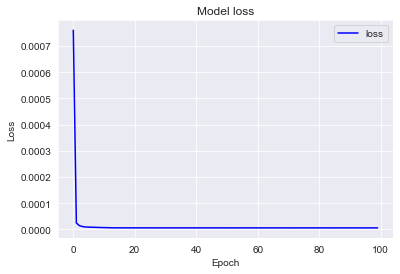

In [112]:

#overfitting 나오는지 살피기 -> MSE 불안정하는 것은ㄴ상관없음 -/
# 미니 배치 
# 과적합이 나타날까? 확률적으로 좀 더 학습시킨다고 하더라도 의미가 없는 결과가 나올것임.
# 모델 손실 함수 시각화
plt.plot(history['loss'], 'b-', label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



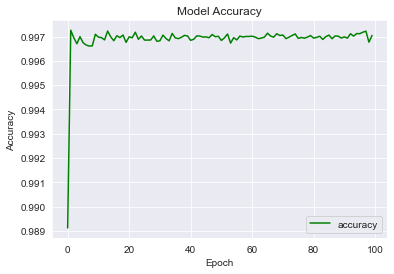

In [113]:
# 모델 정확도 시각화
plt.plot(history['accuracy'], 'g-', label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [114]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'Target': y_test})
error_df

,reconstruction_error,Target
763831,2.551186e-07,0
365470,6.872956e-07,1
551168,1.059837e-06,1
515052,2.556383e-06,0
231268,2.450733e-06,1
...,...,...
358070,2.994172e-06,1
263860,1.114449e-06,1
60431,1.124125e-06,0
53981,9.348013e-07,0


In [115]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

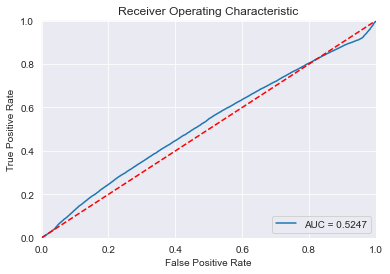

In [116]:
fpr, tpr, thresholds = roc_curve(error_df.Target, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

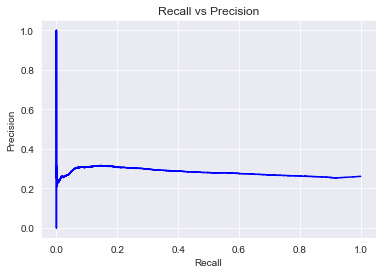

In [117]:
precision, recall, th = precision_recall_curve(error_df.Target, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

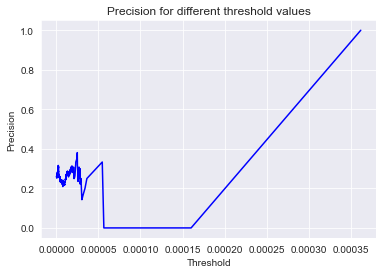

In [118]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

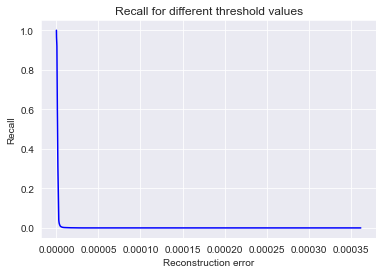

In [119]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

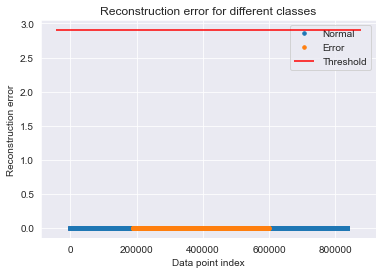

In [123]:
threshold = 2.9


groups = error_df.groupby('Target')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Error" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [74]:
# dissoul -> scaling 진행 / 
dx_MnX = dissoul_MnX[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT']]
dy_Mnx = dissoul_MnX[['TAG']]


In [75]:
dx_MnX

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT
0,0.690083,0.431227,0.536565
1,0.458678,0.289963,0.517857
2,0.586777,0.572491,0.517007
3,0.235537,0.788104,0.515306
6,0.280992,0.788104,0.511905
...,...,...,...
835189,0.694215,0.390335,0.276361
835191,0.524793,0.297398,0.273810
835192,0.677686,0.591078,0.272959
835196,0.260331,0.765799,0.269558


In [15]:
#

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector 
from keras.models import Model
from keras import regularizers
from sklearn.preprocessing import Stan


In [34]:
# dissoul -> scaling 진행 / 
dx = dissoul[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT']]
dy = dissoul[['TAG']]

In [35]:
dissoul_x_train, dissoul_x_test, dissoul_y_train, dissoul_y_test = train_test_split(dx, dy, train_size=0.7, test_size=0.3, random_state=42)

In [36]:
dissoul_x_train

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT
332979,0.402649,-0.010545,0.034094
288713,-1.744636,1.431018,-0.513185
626077,0.747275,0.736289,0.060575
408687,0.561707,0.354188,-0.318989
248438,0.058023,-1.087375,0.007613
...,...,...,...
471356,-1.028874,1.413650,0.727020
668676,-0.869816,1.257336,-0.777998
236631,-0.445661,-1.295794,-0.720622
263131,-0.578210,-1.156848,0.731434


In [54]:
dissoul_y_train.to_numpy()

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [37]:
X_train_AE = dissoul_x_train.copy()

In [39]:
n_input = 3
n_output = 3

In [40]:
x_Input = Input(batch_shape=(None, n_input))
x_Encoder1 = Dense(256, activation='relu')(x_Input)
x_Encoder1 = Dropout(0.3)(x_Encoder1)
x_Encoder2 = Dense(512, activation='relu')(x_Encoder1)
x_Encoder2 = Dropout(0.2)(x_Encoder2)
y_Decoder1 = Dense(256, activation='relu')(x_Encoder2)
y_Decoder1 = Dropout(0.3)(y_Decoder1)
y_Decoder2 = Dense(n_output, activation='linear')(y_Decoder1)


2022-10-31 10:38:13.285781: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
model = Model(x_Input, y_Decoder2)
model.compile(loss='mse', optimizer=Adam(lr=0.001))
print("====== 모델 전체 구조 ======")
print(model.summary())


====== 모델 전체 구조 ======
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 25

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [42]:
# 모델 파라미터 및 조기 종료 조건
EPOCHS = int(input('학습 횟수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))
es = EarlyStopping(monitor='loss', patience=5, verbose=1)


학습 횟수 설정: 100
배치 사이즈 설정: 12


In [43]:
hist = model.fit(X_train_AE, X_train_AE, 
                 epochs=EPOCHS,
                 batch_size=BATCH,
                 callbacks=[es],
                 shuffle=True)

2022-10-31 10:39:25.468660: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
26597/26597 [==============================] - 35s 1ms/step - loss: 0.0256
Epoch 2/100
26597/26597 [==============================] - 35s 1ms/step - loss: 0.0221
Epoch 3/100
26597/26597 [==============================] - 35s 1ms/step - loss: 0.0216
Epoch 4/100
26597/26597 [==============================] - 40s 1ms/step - loss: 0.0214
Epoch 5/100
26597/26597 [==============================] - 35s 1ms/step - loss: 0.0211
Epoch 6/100
26597/26597 [==============================] - 34s 1ms/step - loss: 0.0210
Epoch 7/100
26597/26597 [==============================] - 34s 1ms/step - loss: 0.0210
Epoch 8/100
26597/26597 [==============================] - 34s 1ms/step - loss: 0.0210
Epoch 9/100
26597/26597 [==============================] - 34s 1ms/step - loss: 0.0210
Epoch 10/100
26597/26597 [==============================] - 34s 1ms/step - loss: 0.0209
Epoch 11/100
26597/26597 [==============================] - 34s 1ms/step - loss: 0.0209
Epoch 12/100
26597/26597 [===============

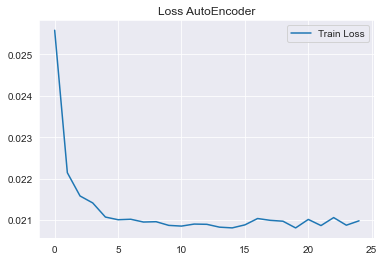

In [45]:
# loss 그래프
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss AutoEncoder')
plt.legend()
plt.show()


In [46]:
# 예측
y_pred_AE = model.predict(X_train_AE)

In [48]:
def calc_distance(origin, pred):
    dist = []
    for i in range(len(pred)):
        dist.append(np.sqrt(np.sum(np.square(origin[i]-pred[i]))))
    return pd.Series(dist)

In [50]:
distance_AE = calc_distance(X_train_AE, y_pred_AE)

KeyError: 0